In [121]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')

from sklearn.compose import ColumnTransformer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [123]:
del df['SOUID']
del df['Q_TG']

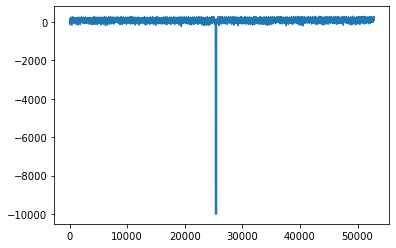

In [124]:
df['TG'].plot()              # check values, will need to fill in missing values

In [125]:
df.index[df['TG']<-800]

Int64Index([25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324,
            25325,
            ...
            25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509,
            25510],
           dtype='int64', length=195)

In [126]:
df.set_index(pd.to_datetime(df['DATE'].astype(str)), inplace=True)     # convert to datetime format
del(df['DATE'])
df['TG'] = df['TG'] / 10
df.head()

,TG
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [127]:
#df.drop(df[(df.index.month==2) & (df.index.day==29)], axis = 0)
dfsubset = df[(df.index.month==2) & (df.index.day==29)]                      # drop feb 29 values

In [128]:
df=df.drop(dfsubset.index)

In [129]:
patch44 = df.loc['1944/04/25':'1944/11/05', 'TG']                    ## fix the missing values
patch46 = df.loc['1946/04/25':'1946/11/05', 'TG']

avg = (patch44.values + patch46.values) / 2                          # mean of previous and next year

df.loc['1945/04/25':'1945/11/05', 'TG'] = avg

In [130]:
df.loc['1944/01/01':'1944/12/31', 'TG']

DATE
1944-01-01    1.8
1944-01-02    6.8
1944-01-03    5.3
1944-01-04    0.4
1944-01-05   -1.9
             ... 
1944-12-27   -6.6
1944-12-28   -3.4
1944-12-29   -5.2
1944-12-30   -4.0
1944-12-31   -0.8
Name: TG, Length: 365, dtype: float64

In [131]:
# add timestep values
df['timestep']=range(len(df.index))

In [132]:
df_train = df['1876-01':'1999-12'].copy()              # train-test split
df_test = df['2000-01':'2020-09'].copy()

In [133]:
plt.rcParams["figure.figsize"] = [20, 10]

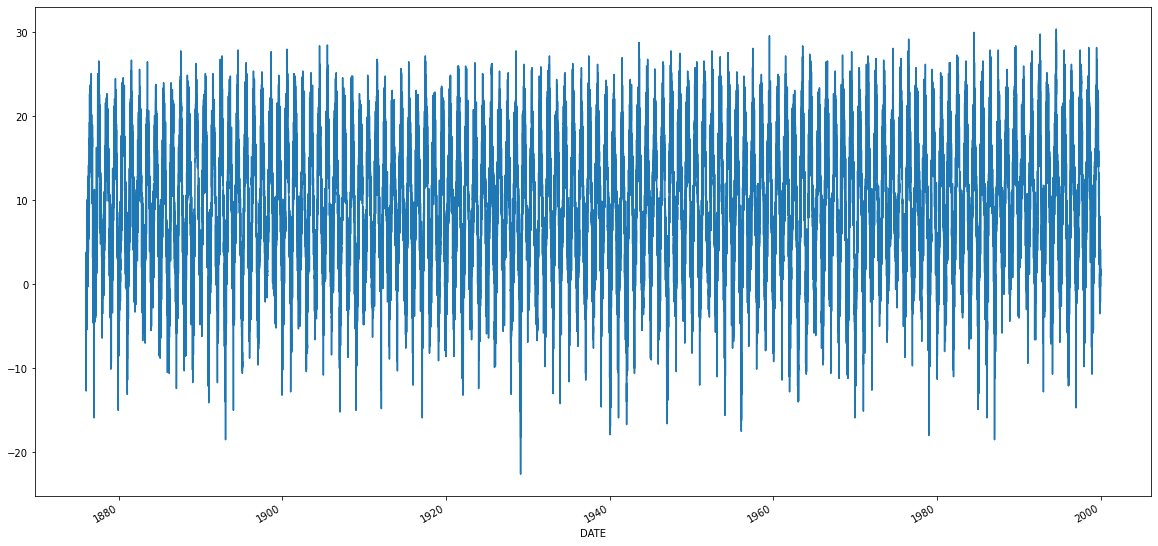

In [134]:
df_train['TG'].plot()

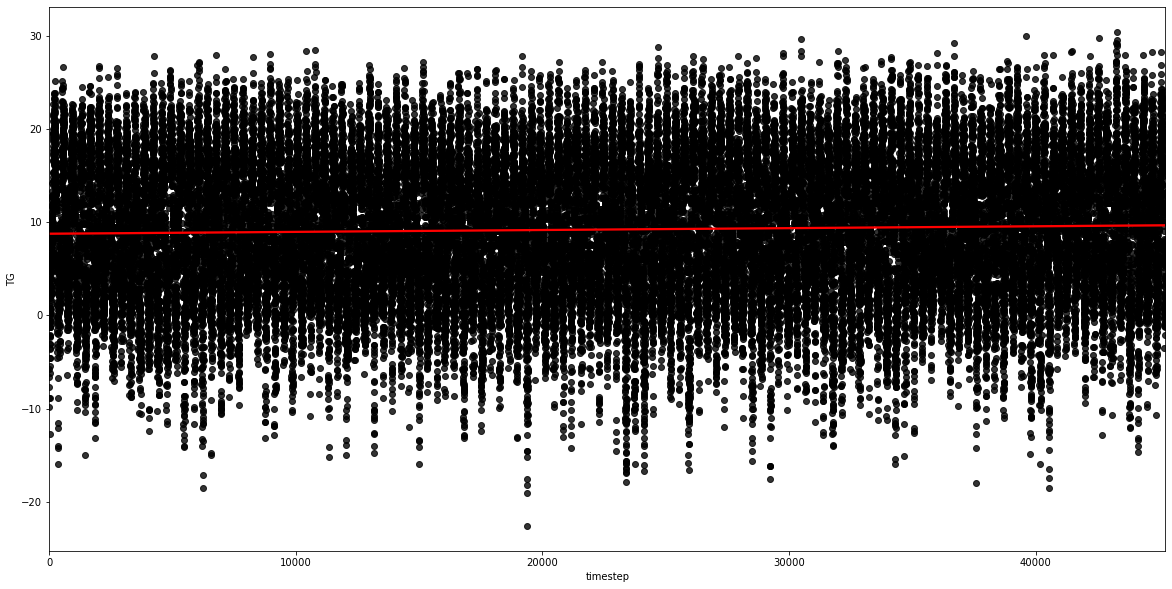

In [135]:
sns_plot = sns.regplot(x = 'timestep', y = 'TG', data = df_train, scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [136]:
df_train.head()

,TG,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [137]:
df_train['difference'] = df_train['TG'].diff(periods=1)             # Create difference column for removing trend

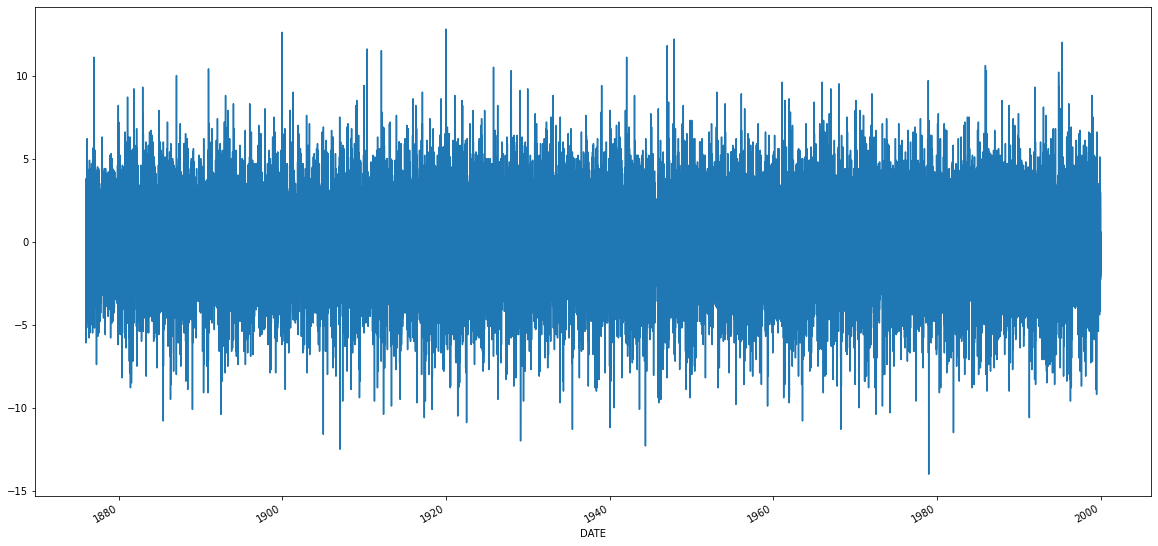

In [138]:
df_train['difference'].plot()

In [139]:
df_train['monthly mean'] = df_train.groupby(df_train.index.month)['difference'].transform('mean') # seasonality: create mean monthly difference column

In [140]:
monthlymeans = list(df_train.groupby(df_train.index.month)['difference'].mean()) # also save into a list

In [141]:
monthlymeans

[-0.007754358574030697,
 0.08309331797235031,
 0.14479708636836627,
 0.14723118279569825,
 0.17049947970863638,
 0.06573924731182815,
 0.03207596253902184,
 -0.0910509885535903,
 -0.1393413978494621,
 -0.18717481789802254,
 -0.12784946236559122,
 -0.08459937565036431]

In [142]:
df_train['deseasonalized'] = df_train['difference'] - df_train['monthly mean']

In [143]:
df_train['deseasonalized']

DATE
1876-01-01         NaN
1876-01-02    0.307754
1876-01-03   -2.192246
1876-01-04   -6.092246
1876-01-05   -3.992246
                ...   
1999-12-27   -1.015401
1999-12-28    0.284599
1999-12-29    0.284599
1999-12-30    0.684599
1999-12-31   -1.915401
Name: deseasonalized, Length: 45260, dtype: float64

In [144]:
ypred=df_train['deseasonalized'].mean()   # baseline (mean) prediction after trend and seasonality is removed

In [145]:
ypred

2.742012189677191e-17

In [146]:
df_train.head()

,TG,timestep,difference,monthly mean,deseasonalized
DATE,,,,,
1876-01-01,2.2,0,NaN,-0.007754,NaN
1876-01-02,2.5,1,0.3,-0.007754,0.307754
1876-01-03,0.3,2,-2.2,-0.007754,-2.192246
1876-01-04,-5.8,3,-6.1,-0.007754,-6.092246
1876-01-05,-9.8,4,-4.0,-0.007754,-3.992246


In [147]:
y_train = df_train['deseasonalized'][1:]       # dropping first NaN value

In [148]:
y_train

DATE
1876-01-02    0.307754
1876-01-03   -2.192246
1876-01-04   -6.092246
1876-01-05   -3.992246
1876-01-06    2.107754
                ...   
1999-12-27   -1.015401
1999-12-28    0.284599
1999-12-29    0.284599
1999-12-30    0.684599
1999-12-31   -1.915401
Name: deseasonalized, Length: 45259, dtype: float64

In [149]:
#df_train['y-2'] = df_train['deseasonalized'].shift(2)

In [150]:
df_train.head()

,TG,timestep,difference,monthly mean,deseasonalized
DATE,,,,,
1876-01-01,2.2,0,NaN,-0.007754,NaN
1876-01-02,2.5,1,0.3,-0.007754,0.307754
1876-01-03,0.3,2,-2.2,-0.007754,-2.192246
1876-01-04,-5.8,3,-6.1,-0.007754,-6.092246
1876-01-05,-9.8,4,-4.0,-0.007754,-3.992246


In [151]:
y_train = df_train['TG'][1:]       # dropping NaN values

In [152]:
x_train = df_train['timestep'][1:].to_frame()

In [153]:
x_train['dayofyear']=x_train.index.dayofyear

In [154]:
x_train

,timestep,dayofyear
DATE,,
1876-01-02,1,2
1876-01-03,2,3
1876-01-04,3,4
1876-01-05,4,5
1876-01-06,5,6
...,...,...
1999-12-27,45255,361
1999-12-28,45256,362
1999-12-29,45257,363


In [155]:
tr = ColumnTransformer([
    ('onehotday', OneHotEncoder(sparse=False, drop='first', handle_unknown='error'), ['dayofyear']), 
    ('timesteps', 'passthrough', ['timestep']),
])

In [156]:
tr.fit(x_train)
x_train_trans = tr.transform(x_train)

In [157]:
x_train_trans

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        3.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.5257e+04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.5258e+04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        4.5259e+04]])

In [158]:
x_test = df_test[['timestep']]

In [159]:
x_test['dayofyear']=x_test.index.dayofyear

In [160]:
x_test

,timestep,dayofyear
DATE,,
2000-01-01,45260,1
2000-01-02,45261,2
2000-01-03,45262,3
2000-01-04,45263,4
2000-01-05,45264,5
...,...,...
2020-09-26,52828,270
2020-09-27,52829,271
2020-09-28,52830,272


In [161]:
x_test_trans = tr.transform(x_test)

In [162]:
linreg = LinearRegression()

In [163]:
linreg.fit(x_train_trans, y_train)

LinearRegression()

In [164]:
cross_val_result = cross_val_score(linreg, x_train_trans, y_train)

In [165]:
cross_val_result

array([0.77924762, 0.75404626, 0.76206073, 0.77492724, 0.7521523 ])

In [166]:
linreg.score(x_train_trans, y_train)

0.7696093921215018

In [167]:
df_test_predict = df_test.drop('TG',axis = 1)

In [168]:
df_test_predict

,timestep
DATE,
2000-01-01,45260
2000-01-02,45261
2000-01-03,45262
2000-01-04,45263
2000-01-05,45264
...,...
2020-09-26,52828
2020-09-27,52829
2020-09-28,52830


In [169]:
predictions = linreg.predict(x_test_trans)

In [170]:
predictions

array([ 0.17568281,  0.51269494,  0.82801752, ..., 12.91553315,
       12.93932347, 12.66916218])

In [171]:
df_test['TGPRED']=predictions    # this will be the prediction column

In [172]:
df_test

,TG,timestep,TGPRED
DATE,,,
2000-01-01,1.4,45260,0.175683
2000-01-02,3.9,45261,0.512695
2000-01-03,5.9,45262,0.828018
2000-01-04,5.3,45263,0.715114
2000-01-05,3.0,45264,0.621566
...,...,...,...
2020-09-26,10.4,52828,13.173194
2020-09-27,9.9,52829,13.082469
2020-09-28,13.9,52830,12.915533


In [104]:
#ypred = df_test[df_test['timestep']==45260]['TGPRED']

In [105]:
#ypred + 2

DATE
2000-01-01    1.715216
Name: TGPRED, dtype: float64

In [106]:
#currmonth = df_test[df_test['timestep']==45260].index.month[0]        # let's predict the first step of the test dataframe
#ypred = df_test[df_test['timestep']==45260]['TGPRED']
#ypred = df_test[df_test['timestep']==45260]['TGPRED']
#ypred_reconstruced = ypred + monthlymeans[currmonth-1]                # add back monthly mean
# De-diff using the last observed value from the train dataframe:
#ypred_temp_reconstruced = df_train[df_train['timestep']==45259]['TG'][0] + ypred_reconstruced
#df_test.loc[df_test['timestep']==45260,'TGPRED'] = ypred_temp_reconstruced

In [107]:
df_test.head()

,TG,timestep,TGPRED
DATE,,,
2000-01-01,1.4,45260,-0.492538
2000-01-02,3.9,45261,0.321610
2000-01-03,5.9,45262,0.323223
2000-01-04,5.3,45263,-0.105003
2000-01-05,3.0,45264,-0.085648


In [108]:
# Do the prediction for the test dataframe step by step:
#for i in range(45261, 52833):
#    ypred = df_test[df_test['timestep']==i]['TGPRED']
#    currmonth = df_test[df_test['timestep']==i].index.month[0]
#    ypred_reconstruced = ypred + monthlymeans[currmonth-1]
#    ypred_temp_reconstruced = df_test[df_test['timestep']==i-1]['TGPRED'][0] + ypred_reconstruced
#    df_test.loc[df_test['timestep']==i,'TGPRED'] = ypred_temp_reconstruced

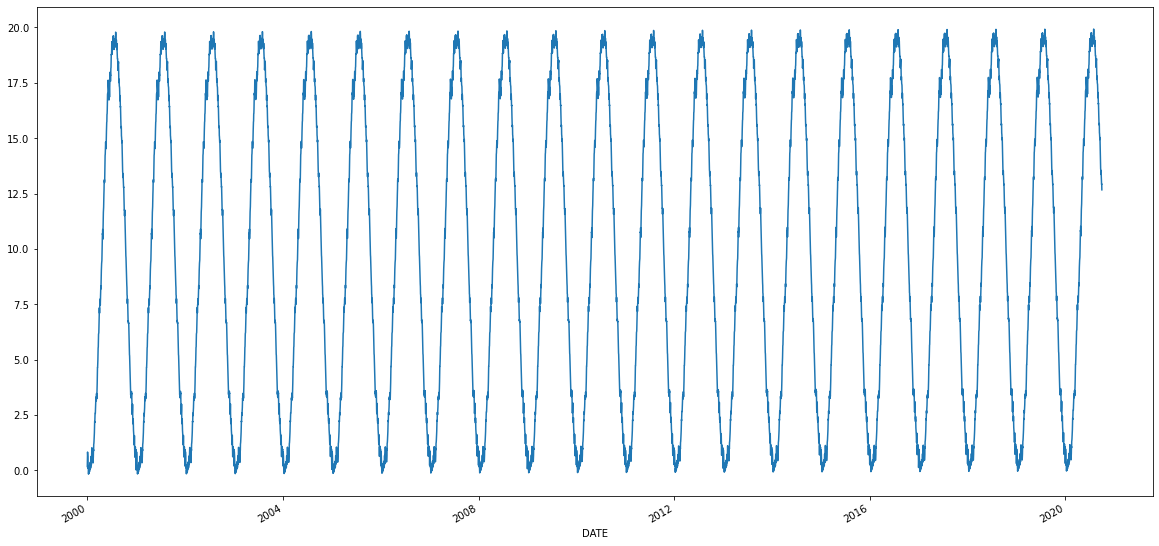

In [173]:
df_test['TGPRED'].plot()

In [175]:
del df_test['timestep']            # don't really need this anymore after prediction

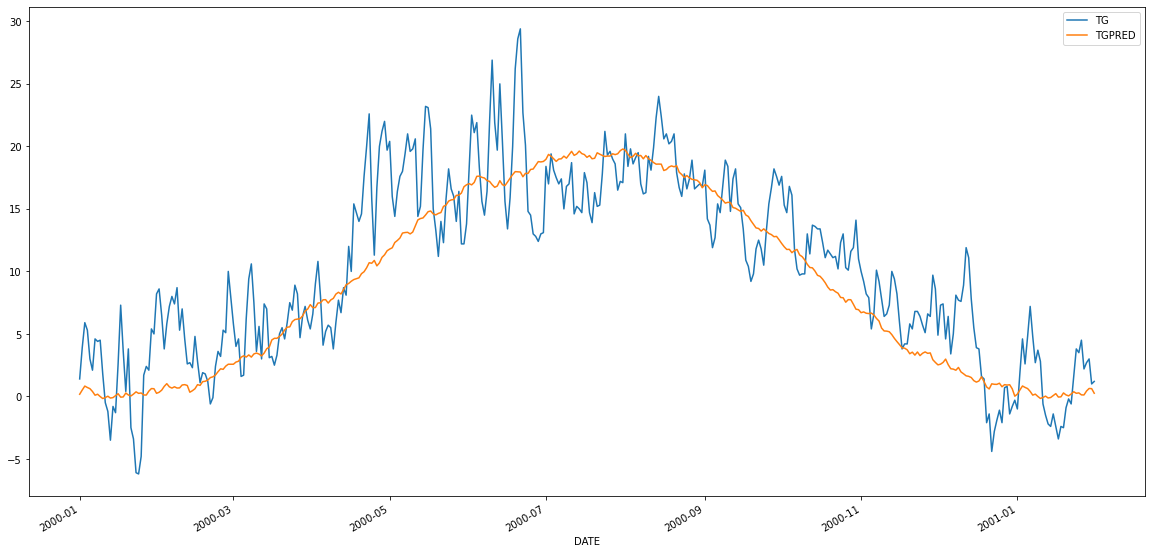

In [176]:
df_test['2000-01':'2001-01'].plot()          # display baseline model for a year

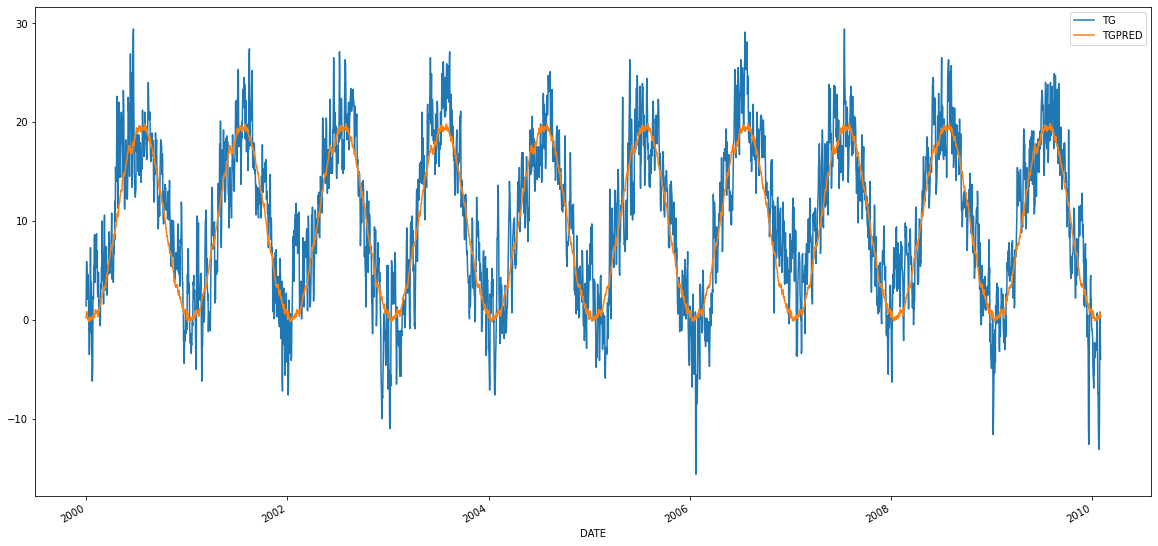

In [177]:
df_test['2000-01':'2010-01'].plot()          # display baseline model for a year

In [178]:
df_test

,TG,TGPRED
DATE,,
2000-01-01,1.4,0.175683
2000-01-02,3.9,0.512695
2000-01-03,5.9,0.828018
2000-01-04,5.3,0.715114
2000-01-05,3.0,0.621566
...,...,...
2020-09-26,10.4,13.173194
2020-09-27,9.9,13.082469
2020-09-28,13.9,12.915533


In [179]:
print(mean_squared_error(df_test['TG'], df_test['TGPRED']))

14.808738864725877
